In [157]:
from sentence_transformers import SentenceTransformer, util
import pandas as pd
from tqdm import tqdm
from langchain_openai import AzureOpenAIEmbeddings
import json
import numpy as np
import torch
import time
import random
import ast
import matplotlib.pyplot as plt
import os

Let's fetch the dataframes.

In [158]:
from data_extractor import Extractor
extractor_instance = Extractor()
extractor_instance.extract(location="./data/results/df_combined.csv")

df_combined = pd.read_csv("data/results/df_combined.csv")
df_combined.sample(n=3)

Comp domain df length: 1912  - VTT domain df length: 4927
Example of text to compare: FiR 1 - FiR 1 is a Triga-type nuclear research reactor located in Otaniemi, Espoo, Finland, decommissioned by VTT after serving since 1962, used for nuclear research, training, and medical radiation therapy. | Developed by VTT Technical Research Centre of Finland Ltd.


,Unnamed: 0.1,Document number,VAT id,relationship description,source id,source type,source english_id,source description,relationship type,target id,target type,target english_id,target description,Link Source Text,Source Text,text_to_compare,Unnamed: 0,Source Company
318,318,VTT70,FI01165106,Elisa Corporation was involved in the developm...,MVS tool,Innovation,MVS tool,A cyber security measurement and visualisation...,DEVELOPED_BY,temp_1252,Organization,Elisa Corporation,A Finnish telecommunications company working o...,https://www.vttresearch.com/en/news-and-ideas/...,Skip to main content Beyond the obvious Open m...,MVS tool - A cyber security measurement and vi...,NaN,NaN
639,639,VTT152,FI18523029,Suur-Savon Sähkö was involved in the KYBER-ENE...,KYBER-ENE project cyber threat management model,Innovation,KYBER-ENE project cyber threat management model,A cyber threat management model developed in t...,DEVELOPED_BY,temp_1319,Organization,Suur-Savon Sähkö,A Finnish energy company involved in the KYBER...,https://www.vttresearch.com/en/news-and-ideas/...,Skip to main content Beyond the obvious Open m...,KYBER-ENE project cyber threat management mode...,NaN,NaN
4964,4964,COMP25,NaN,The Kesko Oyj Environmental reporting principl...,Kesko Oyj Environmental reporting principles,Innovation,Kesko Oyj Environmental reporting principles,A set of principles and methodologies used by ...,DEVELOPED_BY,FI01098628,Organization,Kesko Oyj,A Finnish company that manages properties and ...,https://www.kesko.fi/493134/globalassets/pdf-t...,Kesko Oyj Environmental reporting principles \...,Kesko Oyj Environmental reporting principles -...,128.0,KESKO OYJ


In [ ]:
from embedding_generator import EmbeddingGenerator, LocalEmbeddingProvider, OpenAIEmbeddingProvider

# Configuration
METHOD = "openai"  # Supports local and openai
MODEL_NAME = "all-mpnet-base-v2"  # For local embeddings
MODEL_KEY = "gpt-4.1-mini"  # For OpenAI embeddings, I think only this works

# File paths
input_file = "data/results/df_combined.csv"
output_file = "data/results/embeddings.csv"

provider = OpenAIEmbeddingProvider(MODEL_KEY) if METHOD == "openai" else LocalEmbeddingProvider(MODEL_NAME)
generator = EmbeddingGenerator(provider)

result_df = None
if os.path.exists(output_file):
    result_df = pd.read_csv(output_file)
    print(f"Loaded {len(result_df)} pairs from {output_file}")
else:
    result_df = generator.generate_embeddings(input_file, output_file)

result_df["embedding"] = result_df["embedding"].apply(ast.literal_eval)

2025-05-31 17:15:54,187 - INFO - Initialized OpenAI embedding model with key: gpt-4.1-mini


Loaded 6839 pairs from data/results/embeddings.csv


In [9]:
result_df.head()

,Unnamed: 0.1,Document number,VAT id,relationship description,source id,source type,source english_id,source description,relationship type,target id,...,target english_id,target description,Link Source Text,Source Text,text_to_compare,Unnamed: 0,Source Company,embedding,embedding_provider,embedding_dimension
0,0,VTT0,FI10292588,"FiR 1 nuclear research reactor was developed, ...",FiR 1,Innovation,FiR 1,FiR 1 is a Triga-type nuclear research reactor...,DEVELOPED_BY,FI26473754,...,VTT Technical Research Centre of Finland Ltd.,VTT is a Finnish research and innovation partn...,https://www.vttresearch.com/en/news-and-ideas/...,Skip to main content Beyond the obvious Open m...,FiR 1 - FiR 1 is a Triga-type nuclear research...,NaN,NaN,"[-0.018910497426986694, 0.017533520236611366, ...",openai_gpt-4.1-mini,3072
1,1,VTT0,FI10292588,Centre for Nuclear Safety is being developed a...,Centre for Nuclear Safety,Innovation,Centre for Nuclear Safety,A modern research facility under construction ...,DEVELOPED_BY,FI26473754,...,VTT Technical Research Centre of Finland Ltd.,VTT is a Finnish research and innovation partn...,https://www.vttresearch.com/en/news-and-ideas/...,Skip to main content Beyond the obvious Open m...,Centre for Nuclear Safety - A modern research ...,NaN,NaN,"[-0.009751166217029095, 0.006150579079985619, ...",openai_gpt-4.1-mini,3072
2,2,VTT3,FI08932048,The innovation approach 'Beyond the obvious' i...,Beyond the obvious,Innovation,Beyond the obvious,An innovation approach promising to provide so...,DEVELOPED_BY,FI26473754,...,VTT Technical Research Centre of Finland Ltd,A visionary research and innovation partner fo...,https://www.vttresearch.com/en/news-and-ideas/...,Skip to main content Beyond the obvious Open m...,Beyond the obvious - An innovation approach pr...,NaN,NaN,"[-0.02210899069905281, -0.002120873425155878, ...",openai_gpt-4.1-mini,3072
3,3,VTT4,FI01111693,Data-Driven Bioeconomy project is developed by...,Data-Driven Bioeconomy project,Innovation,Data-Driven Bioeconomy project,An innovation using Big Data for sustainable u...,DEVELOPED_BY,FI26473754,...,VTT Technical Research Centre of Finland,A Finnish research and innovation partner work...,https://www.vttresearch.com/en/news-and-ideas/...,Skip to main content Beyond the obvious Open m...,Data-Driven Bioeconomy project - An innovation...,NaN,NaN,"[-0.015033945441246033, 0.031899139285087585, ...",openai_gpt-4.1-mini,3072
4,4,VTT4,FI01111693,Data-Driven Bioeconomy project's forestry pilo...,Data-Driven Bioeconomy project,Innovation,Data-Driven Bioeconomy project,An innovation using Big Data for sustainable u...,DEVELOPED_BY,temp_1141,...,MHG Systems,An organization leading pilots developing fore...,https://www.vttresearch.com/en/news-and-ideas/...,Skip to main content Beyond the obvious Open m...,Data-Driven Bioeconomy project - An innovation...,NaN,NaN,"[-0.014490003697574139, 0.016991155222058296, ...",openai_gpt-4.1-mini,3072


In [155]:
def calculate_similar_pairs(embeddings_tensor, threshold=0.8, verbose=True):

    similar_pairs = []

    # Compute cosine similarity matrix
    cos_sim_matrix = util.cos_sim(embeddings_tensor, embeddings_tensor)

    # Get indices of upper triangle (i < j)
    triu_indices = torch.triu_indices(cos_sim_matrix.size(0), cos_sim_matrix.size(1), offset=1)

    # Get similarity scores for upper triangle
    sim_scores = cos_sim_matrix[triu_indices[0], triu_indices[1]]

    # Filter by threshold
    mask = sim_scores > threshold
    i_indices = triu_indices[0][mask].tolist()
    j_indices = triu_indices[1][mask].tolist()
    scores = sim_scores[mask].tolist()

    # Collect similar pairs
    similar_pairs = [(i, j, score) for i, j, score in zip(i_indices, j_indices, scores)]
    
    return similar_pairs

def create_embeddings_tensor(duplicates=False):
    result_df_final = result_df.copy()
    if duplicates == False:
        result_df_final = result_df.drop_duplicates(subset=["source description"]).reset_index(drop=True)

    combined_embeddings = result_df_final["embedding"].tolist()
    combined_texts = result_df_final["text_to_compare"].tolist()

    start_time = time.time()
    embeddings_tensor = torch.stack([torch.tensor(e) for e in combined_embeddings])
    return embeddings_tensor, combined_texts, combined_embeddings, result_df_final

Last datapoint: 27, 0.9940291532763729


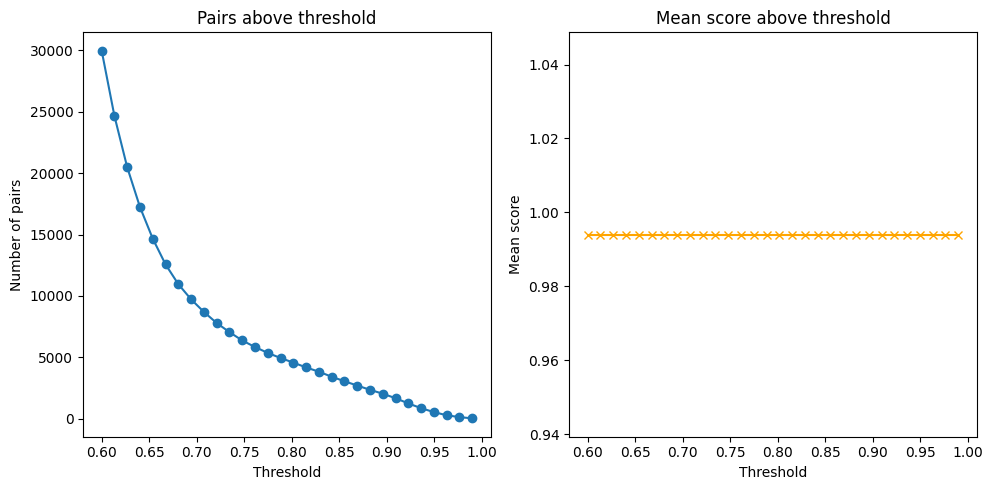

In [ ]:
thresholds = np.linspace(0.6, 0.99, 30)
pair_counts = []
mean_scores = []

embeddings_tensor, combined_texts, combined_embeddings, mutated_result_df = create_embeddings_tensor()

for threshold in thresholds:
    mask = sim_scores > threshold
    similar_pairs = calculate_similar_pairs(embeddings_tensor, threshold=threshold)
    pair_counts.append(len(similar_pairs))
    mean_scores.append(np.mean(scores) if scores else 0)

print(f"Last datapoint: {pair_counts[-1]}, {mean_scores[-1]}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(thresholds, pair_counts, marker='o')
plt.xlabel('Threshold')
plt.ylabel('Number of pairs')
plt.title('Pairs above threshold')

plt.subplot(1, 2, 2)
plt.plot(thresholds, mean_scores, marker='x', color='orange')
plt.xlabel('Threshold')
plt.ylabel('Mean score')
plt.title('Mean score above threshold')

plt.tight_layout()
plt.show()

# Let's group the pairs

In [137]:
def group_similar_pairs(similar_pairs):
    """
    Group pairs that share elements into connected components.
    
    Args:
        similar_pairs: List of tuples (i, j, score) where i and j are indices
                      and score is the similarity score
    
    Returns:
        List of groups, where each group is a set of indices
    """
    from collections import defaultdict
    
    # Create adjacency list representation
    graph = defaultdict(set)
    
    # Build the graph from pairs
    for i, j, score in similar_pairs:
        graph[i].add(j)
        graph[j].add(i)
    
    # Find connected components using DFS
    visited = set()
    groups = []
    
    def dfs(node, current_group):
        if node in visited:
            return
        visited.add(node)
        current_group.add(node)
        
        # Visit all neighbors
        for neighbor in graph[node]:
            dfs(neighbor, current_group)
    
    # Find all connected components
    for node in graph:
        if node not in visited:
            current_group = set()
            dfs(node, current_group)
            if current_group:  # Only add non-empty groups
                groups.append(current_group)
    
    return groups



In [138]:
import random
similar_pairs = calculate_similar_pairs(embeddings_tensor)
groups_sorted = group_similar_pairs(similar_pairs)
# Ensure there are at least 5 groups
num_samples = min(5, len(groups_sorted))
random_groups = random.sample(groups_sorted, num_samples)

print(f"\nSample of 10 random groups:")
for i, group in enumerate(random_groups):
    print(f"\nGroup {i+1} (size: {len(group)}):")
    for idx in sorted(group):
        print(f"  Index {idx}: {combined_texts[idx][:100]}...")


Sample of 10 random groups:

Group 1 (size: 3):
  Index 394: temp_1255 - A European project coordinated by VTT studying the use of hydrogen as fuel for different...
  Index 395: temp_1255 - A European project coordinated by VTT studying the use of hydrogen as fuel for different...
  Index 396: temp_1255 - A European project coordinated by VTT studying the use of hydrogen as fuel for different...

Group 2 (size: 6):
  Index 3: Data-Driven Bioeconomy project - An innovation using Big Data for sustainable use of resources in ag...
  Index 4: Data-Driven Bioeconomy project - An innovation using Big Data for sustainable use of resources in ag...
  Index 4750: Big data solutions for sustainable resource use in agriculture, forestry and fisheries - A set of ne...
  Index 4751: Big data solutions for sustainable resource use in agriculture, forestry and fisheries - A set of ne...
  Index 4752: Big data solutions for sustainable resource use in agriculture, forestry and fisheries - A set of ne

Last datapoint: 26, 2.0384615384615383


<Figure size 1000x500 with 0 Axes>

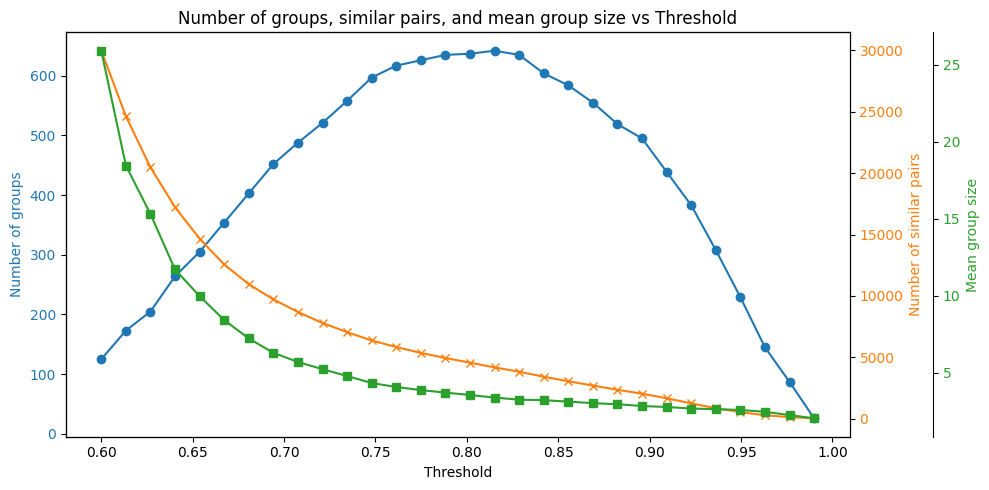

In [139]:
thresholds = np.linspace(0.6, 0.99, 30)
pair_counts = []
pair_sizes = []
mean_group_sizes = []

for threshold in thresholds:
    mask = sim_scores > threshold
    i_indices = triu_indices[0][mask].tolist()
    j_indices = triu_indices[1][mask].tolist()
    scores = sim_scores[mask].tolist()
    similar_pairs = [(i, j, score) for i, j, score in zip(i_indices, j_indices, scores)]
    groups = group_similar_pairs(similar_pairs)
    pair_counts.append(len(groups))
    pair_sizes.append(len(similar_pairs))  # Track number of similar pairs
    if groups:
        mean_group_sizes.append(np.mean([len(g) for g in groups]))
    else:
        mean_group_sizes.append(0)

print(f"Last datapoint: {pair_counts[-1]}, {mean_group_sizes[-1]}")

plt.figure(figsize=(10, 5))
fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:blue'
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Number of groups', color=color)
ax1.plot(thresholds, pair_counts, marker='o', color=color, label='Number of groups')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Number of similar pairs', color=color)
ax2.plot(thresholds, pair_sizes, marker='x', color=color, label='Number of similar pairs')
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()
color = 'tab:green'
ax3.spines['right'].set_position(('outward', 60))
ax3.set_ylabel('Mean group size', color=color)
ax3.plot(thresholds, mean_group_sizes, marker='s', color=color, label='Mean group size')
ax3.tick_params(axis='y', labelcolor=color)

plt.title('Number of groups, similar pairs, and mean group size vs Threshold')
fig.tight_layout()
plt.show()

# Let's create the final groups and grahp

In [ ]:
embeddings_tensor, combined_texts, combined_embeddings = create_embeddings_tensor()

In [144]:
similar_pairs_final = calculate_similar_pairs(embeddings_tensor, threshold=0.8)

In [145]:
groups_final = group_similar_pairs(similar_pairs_final)

In [152]:

random_groups = random.sample(groups_final, 10)

print(f"\nSample of 10 random groups:")
for i, group in enumerate(random_groups):
    print(f"\nGroup {i+1} (size: {len(group)}):")
    for idx in sorted(group):
        print(f"  Index {idx}: {combined_texts[idx][:100]}...")
        print(f"{result_df[]}")


Sample of 10 random groups:

Group 1 (size: 3):
  Index 5675: Airspace establishment for unmanned aerial systems in Finland - The establishment of airspaces for d...
  Index 6326: EU Regulation for Establishing Airspaces for Unmanned Aerial Systems - A new regulation implemented ...
  Index 6551: airspaces for unmanned aerial systems, i.e. drones, established in Finland as of 26 January 2023 - T...

Group 2 (size: 6):
  Index 2833: sustainable ECG patch - A new sustainable version of ECG patch developed by VTT, designed to be envi...
  Index 2834: sustainable ECG patch - A new sustainable version of ECG patch developed by VTT, designed to be envi...
  Index 2835: sustainable ECG patch - A new sustainable version of ECG patch developed by VTT, designed to be envi...
  Index 2849: kestävä EKG-laastari - Development of a sustainable and environmentally friendly EKG patch for medic...
  Index 4329: biohajoavan EKG-laastarin - A biodegradable ECG patch developed by VTT combining nanocellul